# Обучение DQN для игры в “Pong-v0”.

In [1]:
import gym
import numpy as np
import cv2
from collections import deque
import matplotlib.pyplot as plt

In [6]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [7]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2021-10-29 11:27:25--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M  9.23MB/s    in 1.1s    

2021-10-29 11:27:26 (9.23 MB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK
copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (

In [8]:
env = gym.make('Pong-v0')

In [9]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [10]:
state = env.reset()

In [11]:
def preprocess_frame(frame):
    
    
    bkg_color = np.array([144, 72, 17])
    img = np.mean(frame[34:-16:2,::2]-bkg_color, axis=-1)/255.
    resized_image = img
    
    return resized_image

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    #print(frame)
    stack_size = 4
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((80,80), dtype=np.uint8) for i in range(stack_size)], maxlen=4)
        # Because we're in a new episode, copy the same frame 4x
        for i in range(stack_size):
            stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2).transpose(2, 0, 1)
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)
        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2).transpose(2, 0, 1)
        
    return stacked_state, stacked_frames


stacked_frames = deque([np.zeros((80,80), dtype=np.uint8) for i in range(4)], maxlen=4)

# DQN

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, states, action_size):
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(4, 32, (8, 8), stride=4)
        self.conv2 = nn.Conv2d(32, 64, (4, 4), stride=2)
        self.conv3 = nn.Conv2d(64, 64, (3, 3), stride=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2304, 512)
        self.fc2 = nn.Linear(512, action_size)
        
    def forward(self, state):
       
        x = F.relu(self.conv1(state))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Agent():
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(0)

        ## hyperparameters
        self.buffer_size = 5000
        self.batch_size = 32
        self.gamma = 0.99
        self.lr = 0.0001
        self.update_every = 4
        self.update_every_target = 1000        
        self.learn_every_target_counter = 0
        # Q-Network
        self.local = DQN(state_size, action_size).to(device)
        self.target = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.local.parameters(), lr=self.lr)

        # Replay memory
        self.memory = deque(maxlen=self.buffer_size)  
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        # Initialize time step (for updating every few steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.append(self.experience(state[None], action, reward, next_state[None], done))
        
        # Learn every update_every time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.sample_experiences()
                self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        # Epsilon-greedy action selection
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.local.eval()
            with torch.no_grad():
                action_values = self.local(state)
            self.local.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        self.learn_every_target_counter+=1
        states, actions, rewards, next_states, dones = experiences
       # Get expected Q values from local model
        Q_expected = self.local(states).gather(1, actions)

        # Get max predicted Q values (for next states) from target model
        _, next_state_actions = self.local(next_states).max(1, keepdim=True)
        #print(next_state_actions)
        Q_targets_next = self.target(next_states).gather(1, next_state_actions)
        #Q_targets_next = self.target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        if self.learn_every_target_counter%1000 ==0:
            self.soft_update()                  


    def soft_update(self):
        print('\ttarget updating')
        self.target.load_state_dict(self.local.state_dict())
        # for target_param, local_param in zip(self.target.parameters(), self.local.parameters()):
        #     target_param.data.copy_(0.02*local_param.data + (1.0-0.02)*target_param.data)

    def sample_experiences(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)

In [14]:
n_episodes=600
max_t=5000
eps_start=1.0
eps_end=0.02
eps_decay=0.995

In [15]:
agent = Agent(state_size, action_size)

Episode 3	Reward -21.0 	Average Score: -21.00 	Epsilon: 0.985074875	target updating
Episode 6	Reward -21.0 	Average Score: -20.83 	Epsilon: 0.9703725093562657	target updating
Episode 9	Reward -19.0 	Average Score: -20.44 	Epsilon: 0.9558895783575597	target updating
Episode 12	Reward -20.0 	Average Score: -20.25 	Epsilon: 0.9416228069143757	target updating
Episode 15	Reward -21.0 	Average Score: -20.40 	Epsilon: 0.9275689688183278	target updating
Episode 19	Reward -21.0 	Average Score: -20.37 	Epsilon: 0.9091562615825302	target updating
Episode 22	Reward -20.0 	Average Score: -20.32 	Epsilon: 0.8955869907338783	target updating
Episode 25	Reward -20.0 	Average Score: -20.28 	Epsilon: 0.8822202429488013	target updating
Episode 29	Reward -21.0 	Average Score: -20.38 	Epsilon: 0.8647077305675338	target updating
Episode 32	Reward -21.0 	Average Score: -20.38 	Epsilon: 0.851801859600347	target updating
Episode 35	Reward -21.0 	Average Score: -20.40 	Epsilon: 0.8390886103705794	target updating

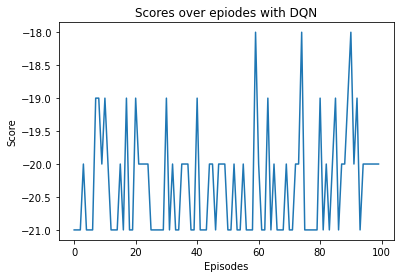

Episode 101	Reward -20.0 	Average Score: -20.31 	Epsilon: 0.6027415843082742	target updating
Episode 104	Reward -20.0 	Average Score: -20.27 	Epsilon: 0.5937455908197752	target updating
Episode 108	Reward -21.0 	Average Score: -20.29 	Epsilon: 0.5819594443402982	target updating
Episode 111	Reward -21.0 	Average Score: -20.31 	Epsilon: 0.5732736268885887	target updating
Episode 114	Reward -21.0 	Average Score: -20.32 	Epsilon: 0.5647174463480732	target updating
Episode 117	Reward -21.0 	Average Score: -20.31 	Epsilon: 0.5562889678716474	target updating
Episode 121	Reward -18.0 	Average Score: -20.32 	Epsilon: 0.5452463540625918	target updating
Episode 124	Reward -20.0 	Average Score: -20.30 	Epsilon: 0.5371084840724134	target updating
Episode 127	Reward -21.0 	Average Score: -20.30 	Epsilon: 0.5290920728090721	target updating
Episode 130	Reward -17.0 	Average Score: -20.24 	Epsilon: 0.5211953074858876	target updating
Episode 133	Reward -19.0 	Average Score: -20.23 	Epsilon: 0.5134164023

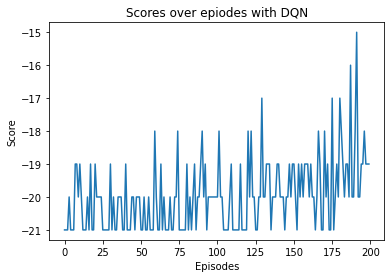

Episode 201	Reward -18.0 	Average Score: -19.61 	Epsilon: 0.36512303261753626	target updating
Episode 204	Reward -18.0 	Average Score: -19.60 	Epsilon: 0.3596735257153405	target updating
Episode 206	Reward -19.0 	Average Score: -19.58 	Epsilon: 0.35608578229633	target updating
Episode 209	Reward -19.0 	Average Score: -19.52 	Epsilon: 0.3507711574848344	target updating
Episode 211	Reward -20.0 	Average Score: -19.52 	Epsilon: 0.3472722151889232	target updating
Episode 213	Reward -20.0 	Average Score: -19.47 	Epsilon: 0.3438081748424137	target updating
Episode 215	Reward -17.0 	Average Score: -19.39 	Epsilon: 0.3403786882983606	target updating
Episode 217	Reward -17.0 	Average Score: -19.37 	Epsilon: 0.33698341088258443	target updating
Episode 220	Reward -17.0 	Average Score: -19.29 	Epsilon: 0.33195389135223546	target updating
Episode 222	Reward -20.0 	Average Score: -19.30 	Epsilon: 0.32864265128599696	target updating
Episode 225	Reward -17.0 	Average Score: -19.28 	Epsilon: 0.32373761

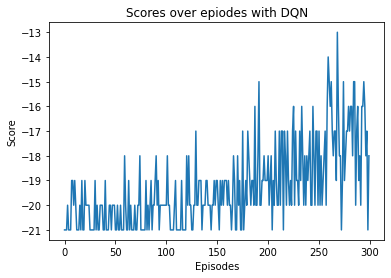

	target updating
Episode 302	Reward -18.0 	Average Score: -17.91 	Epsilon: 0.22007483514733558	target updating
Episode 303	Reward -14.0 	Average Score: -17.86 	Epsilon: 0.2189744609715989	target updating
Episode 306	Reward -20.0 	Average Score: -17.84 	Epsilon: 0.21570623976979014	target updating
Episode 307	Reward -16.0 	Average Score: -17.80 	Epsilon: 0.21462770857094118	target updating
Episode 309	Reward -18.0 	Average Score: -17.76 	Epsilon: 0.21248679717794605	target updating
Episode 311	Reward -17.0 	Average Score: -17.70 	Epsilon: 0.21036724137609603	target updating
Episode 312	Reward -16.0 	Average Score: -17.69 	Epsilon: 0.20931540516921554	target updating
Episode 314	Reward -15.0 	Average Score: -17.65 	Epsilon: 0.20722748400265262	target updating
Episode 316	Reward -19.0 	Average Score: -17.63 	Epsilon: 0.20516038984972615	target updating
Episode 317	Reward -15.0 	Average Score: -17.61 	Epsilon: 0.2041345879004775	target updating
Episode 319	Reward -16.0 	Average Score: -17.

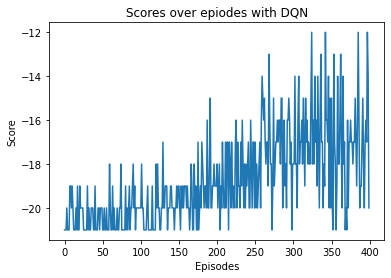

	target updating
Episode 402	Reward -14.0 	Average Score: -16.95 	Epsilon: 0.13331482894782642	target updating
Episode 403	Reward -12.0 	Average Score: -16.93 	Epsilon: 0.13264825480308728	target updating
Episode 405	Reward -19.0 	Average Score: -16.92 	Epsilon: 0.1313250884614265	target updating
Episode 408	Reward -20.0 	Average Score: -17.03 	Epsilon: 0.12936504510050365	target updating
Episode 410	Reward -20.0 	Average Score: -17.07 	Epsilon: 0.12807462877562611	target updating
Episode 412	Reward -17.0 	Average Score: -17.08 	Epsilon: 0.12679708435358925	target updating
Episode 414	Reward -15.0 	Average Score: -17.06 	Epsilon: 0.1255322834371622	target updating
Episode 416	Reward -15.0 	Average Score: -17.01 	Epsilon: 0.1242800989098765	target updating
Episode 417	Reward -16.0 	Average Score: -17.02 	Epsilon: 0.12365869841532712	target updating
Episode 419	Reward -16.0 	Average Score: -16.98 	Epsilon: 0.12242520289863423	target updating
Episode 420	Reward -17.0 	Average Score: -16.9

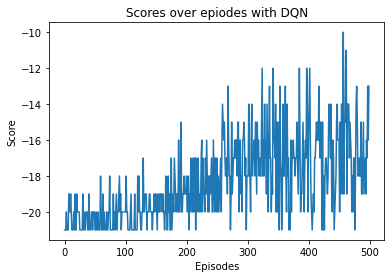

	target updating
Episode 501	Reward -12.0 	Average Score: -16.70 	Epsilon: 0.0811640021330769	target updating
Episode 503	Reward -18.0 	Average Score: -16.73 	Epsilon: 0.08035439121179945	target updating
Episode 504	Reward -9.0 	Average Score: -16.66 	Epsilon: 0.07995261925574046	target updating
Episode 505	Reward -14.0 	Average Score: -16.61 	Epsilon: 0.07955285615946175	target updating
Episode 506	Reward -12.0 	Average Score: -16.53 	Epsilon: 0.07915509187866444	target updating
Episode 508	Reward -16.0 	Average Score: -16.48 	Epsilon: 0.07836551983717477	target updating
Episode 510	Reward -15.0 	Average Score: -16.44 	Epsilon: 0.07758382377679894	target updating
Episode 511	Reward -11.0 	Average Score: -16.38 	Epsilon: 0.07719590465791494	target updating
Episode 513	Reward -14.0 	Average Score: -16.37 	Epsilon: 0.07642587550895225	target updating
Episode 514	Reward -19.0 	Average Score: -16.41 	Epsilon: 0.07604374613140748	target updating
Episode 516	Reward -20.0 	Average Score: -16.

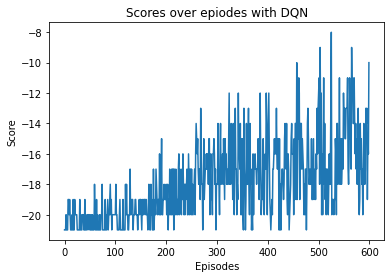

In [16]:
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start
stack_size = 4
stacked_frames  =  deque([np.zeros((80,80), dtype=np.int) for i in range(stack_size)], maxlen=stack_size)    
for i_episode in range(1, n_episodes+1):
    state = env.reset()
    state, frames = stack_frames(stacked_frames, state, True)
    # plt.imshow(state[3,:,:])
    # plt.show()
    score = 0
    for i in range(max_t):
        action = agent.act(state, eps)
        next_state, reward, done, _  = env.step(action)
        next_state, frames = stack_frames(frames, next_state, False)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    print('\rEpisode {}\tReward {} \tAverage Score: {:.2f} \tEpsilon: {}'.format(i_episode,score,np.mean(scores_window), eps), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f} \tEpsilon: {}'.format(i_episode, np.mean(scores_window), eps))
        import matplotlib.pyplot as plt
        %matplotlib inline
        plt.plot(scores)
        plt.title('Scores over epiodes with DQN')
        plt.xlabel('Episodes')
        plt.ylabel('Score')
        plt.show()

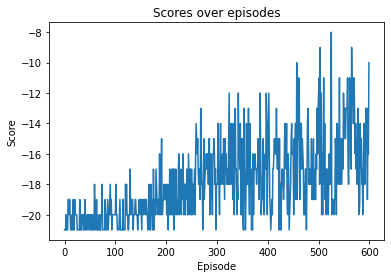

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(scores)
plt.title('Scores over episodes')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()